In [1]:
import os
import sys
from contextlib import nullcontext
import cv2
from tqdm import tqdm
import torch
from PIL import Image
from einops import repeat
from pytorch_lightning import seed_everything
from torch import autocast

from common import parser, OmegaConf, load_model_from_config, latent_to_image, \
    load_img, make_dataset_txt, data_to_dict

lldm_dir = os.path.abspath('./')
sys.path.append(lldm_dir)
from ldm.models.diffusion.ddim import DDIMSampler


# prepare
config = OmegaConf.load('configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, 'models/ldm/stable-diffusion-v1/model.ckpt')
device = torch.device("cuda")
model = model.to(device)
model.model.diffusion_model.register_fusion_func('replace')
sampler = DDIMSampler(model)
seed_everything(42)
model.cond_stage_model = model.cond_stage_model.to(device)
precision_scope = autocast
# main
sampler.make_schedule(ddim_num_steps=50, ddim_eta=0.0, verbose=False)

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['visual_projection.weight', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.layer_norm2.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.mlp.fc1.

Global seed set to 42


In [2]:
import numpy as np
def get_mask_dilate(root_dir, name, dilate_args=None):
    img_mask = cv2.imread(os.path.join(root_dir, 'masks/%s.png' % name), cv2.IMREAD_GRAYSCALE)
    img_mask = img_mask / 255
    img_mask[img_mask !=0] = 1
    if dilate_args is not None:
        kernel = np.ones((dilate_args[0], dilate_args[0]), dtype=np.uint8)
        img_mask = cv2.dilate(img_mask, kernel, dilate_args[1])
    img_mask = cv2.resize(img_mask, (64, 64), interpolation=cv2.INTER_LANCZOS4)
    img_mask[img_mask > 0.5] = 1
    img_mask[img_mask !=1] = 0
    img_mask = torch.Tensor(img_mask).unsqueeze(0).unsqueeze(0).cuda()
    return img_mask

In [11]:
##########################   DIFFEDIT  ##########################################
from common import predict_mask
RATIO = 1
SCALE = 7.5
DDIM_STEPS = 50
root_dir = 'demo/'
out_dir = os.path.join('figures', 'diffedit')
os.makedirs(out_dir, exist_ok=True)


prompts_dict = data_to_dict(make_dataset_txt('demo/orig_prompt.txt'))
edit_prompts = {
#     0: "a duck",
    0: "A photo of a duck on a flower",
    5: "One cat and one tiger sitting on the grass"
}

with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():
            for name in[5]:
                name = str(name)
                img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
                tgt_image = repeat(load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
                prompt = prompts_dict[name]
                print(prompt)
                edit_prompt = edit_prompts[int(name)]

                tgt_mask = None
#                 tgt_mask = get_mask_dilate(root_dir,name)

                uc = None
                if SCALE != 1.0:
                    uc = model.get_learned_conditioning([""])
                src_cond = model.get_learned_conditioning([prompt])
                tgt_cond = model.get_learned_conditioning([edit_prompt])

                t_enc = int(DDIM_STEPS * RATIO)
                init_latent = model.get_first_stage_encoding(model.encode_first_stage(tgt_image))
                
                if tgt_mask is None:
                    print('Diffedit mask generation')
                    tgt_mask = predict_mask(sampler, model, src_cond, tgt_cond, uc, init_latent, 3, DDIM_STEPS)

                latents = sampler.ddim_loop(init_latent, uc, t_enc)

                def corrector_fn(x, index):
                    # index=0-25
                    x = x * tgt_mask + (1 - tgt_mask) * latents[index]
                    return x

                noised_sample = latents[-1].clone()
                recover_latent = sampler.diffedit(noised_sample, tgt_cond, t_enc,
                                                  unconditional_guidance_scale=SCALE,
                                                  unconditional_conditioning=uc,
                                                  corrector_fn=corrector_fn)

                res = latent_to_image(model, recover_latent)

One cat and one dog sitting on the grass
Diffedit mask generation


Encoding image: 100%|███████████████████████████| 50/50 [00:03<00:00, 14.06it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|███████████████████████████| 50/50 [00:05<00:00,  8.45it/s]


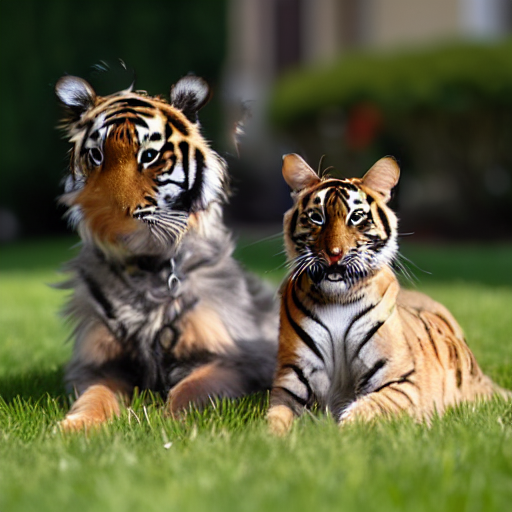

In [12]:
Image.fromarray(res[0])